In [1]:
import pickle as pkl
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader
from tqdm import tqdm

**Utilities**

In [2]:
def remove_double_commas(text):
    """
    Removes double commas from the given text.

    Args:
    text (str): The input string with potential double commas.

    Returns:
    str: The processed string with double commas replaced by a single comma.
    """
    # Define the pattern to match double commas
    pattern = r",,"

    # Use re.sub to replace double commas with a single comma
    cleaned_text = re.sub(pattern, ",", text)

    # Return the cleaned text
    return cleaned_text


def pad_sequence(sequence, max_len):
    """
    Pads the given sequence to the specified maximum length.

    Args:
    sequence (list): The input sequence to pad.
    max_len (int): The maximum length to pad the sequence to.

    Returns:
    list: The padded sequence.
    """
    # Calculate the padding length
    pad_len = max_len - len(sequence) - 1

    # Increase the index of all elements in the sequence by 1
    sequence = [x + 1 for x in sequence]

    # Pad the sequence with zeros
    padded_sequence = [0] + sequence + [15] * pad_len

    # Return the padded sequence
    return padded_sequence

In [3]:
with open(
    "../model=slow-50-tap/model=slow-50_method=tap4x8-w-negatives_return-feats=train_feats.pkl",
    "rb",
) as f:
    train_data = pkl.load(f)

with open(
    "../model=slow-50-tap/model=slow-50_method=tap4x8-w-negatives_return-feats=val_feats.pkl",
    "rb",
) as f:
    val_data = pkl.load(f)

metadata = pd.read_csv(
    "/home/dl18206/Desktop/phd/data/panaf/PanAfFull/notebooks/data/panaf-seq_metadata.csv"
)

with open("../data/behaviours.txt", "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

behaviours_dict = {beh: i for i, beh in enumerate(behaviours)}

# Get the names of the clips
train_name_df = pd.DataFrame(train_data["names"], columns=["name"])
val_name_df = pd.DataFrame(val_data["names"], columns=["name"])

train_name_df = train_name_df.merge(
    metadata[["subject_id", "value"]], left_on="name", right_on="subject_id"
).drop(columns=["subject_id"])

val_name_df = val_name_df.merge(
    metadata[["subject_id", "value"]], left_on="name", right_on="subject_id"
).drop(columns=["subject_id"])


train_name_df["value"] = train_name_df["value"].apply(lambda x: remove_double_commas(x))
val_name_df["value"] = val_name_df["value"].apply(lambda x: remove_double_commas(x))


train_name_df["sequence"] = train_name_df["value"].apply(
    lambda x: (
        [behaviours_dict[i] for i in x.split(",")]
        if "" not in x.split(",")
        else behaviours_dict[x]
    )
)

val_name_df["sequence"] = val_name_df["value"].apply(
    lambda x: (
        [behaviours_dict[i] for i in x.split(",")]
        if "" not in x.split(",")
        else behaviours_dict[x]
    )
)

max_seq_len = 25

train_name_df["sequence"] = train_name_df["sequence"].apply(
    lambda x: pad_sequence(x, max_seq_len)
)
val_name_df["sequence"] = val_name_df["sequence"].apply(
    lambda x: pad_sequence(x, max_seq_len)
)

# Add the imported names and sequences to data
train_data["imported_name"] = train_name_df["name"].values
train_data["sequence"] = train_name_df["sequence"].values

val_data["imported_name"] = val_name_df["name"].values
val_data["sequence"] = val_name_df["sequence"].values

# Check indexing is correct
for n1, n2 in zip(train_data["imported_name"], train_data["names"]):
    assert n1 == n2, f"{n1} != {n2}"

for n1, n2 in zip(val_data["imported_name"], val_data["names"]):
    assert n1 == n2, f"{n1} != {n2}"

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)

train_dataset.set_format(type="torch")
val_dataset.set_format(type="torch")

batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

**Model implementation**

In [4]:
class EncoderDecoderRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0):
        super(EncoderDecoderRNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.sos_idx = 0  # SOS token is at index 0
        self.pad_idx = num_classes + 1  # PAD token is at the last index

        # Encoder
        self.encoder = nn.RNN(
            input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout
        )

        # Decoder
        self.decoder = nn.RNN(
            num_classes + 2, hidden_dim, num_layers, batch_first=True, dropout=dropout
        )

        # Classifier
        self.fc_out = nn.Linear(hidden_dim, num_classes + 2)  # +2 for SOS + PAD token

    def create_mask(self, tgt):
        pad_mask = (tgt != self.pad_idx).float()
        return pad_mask

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        # src shape: [batch_size, sequence_len, input_dim]
        # tgt shape: [batch_size, max_seq_len] (including SOS at index 0 and padding)

        batch_size, max_len = tgt.shape

        # Create mask for padding
        mask = self.create_mask(tgt)

        # Encoder
        _, hidden = self.encoder(src)

        # Decoder
        outputs = torch.zeros(batch_size, max_len, self.num_classes + 2).to(src.device)

        # Use the SOS token (at index 0) as the first decoder input
        decoder_input = (
            F.one_hot(tgt[:, 0], num_classes=self.num_classes + 2).float().unsqueeze(1)
        )  # [B, 1, num_classes + 2]

        for t in range(1, max_len):
            output, hidden = self.decoder(decoder_input, hidden)
            prediction = self.fc_out(output.squeeze(1))

            # Apply mask
            p = prediction * mask[:, t].unsqueeze(1)

            # Store the prediction
            outputs[:, t] = p

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio

            if teacher_force:
                decoder_input = F.one_hot(
                    tgt[:, t].unsqueeze(1), num_classes=self.num_classes + 2
                ).float()
            else:
                top1 = prediction.argmax(1)
                decoder_input = F.one_hot(
                    top1.unsqueeze(1), num_classes=self.num_classes + 2
                ).float()

        return outputs[:, 1:, 1:]

    def inference(self, src, max_len):
        batch_size = src.shape[0]

        # Encoder
        _, hidden = self.encoder(src)

        # Decoder
        outputs = torch.zeros(batch_size, max_len, self.num_classes + 2).to(src.device)

        # Start with SOS token
        decoder_input = F.one_hot(
            torch.full((batch_size, 1), self.sos_idx, device=src.device),
            num_classes=self.num_classes + 2,
        ).float()

        for t in range(1, max_len):
            output, hidden = self.decoder(decoder_input, hidden)
            prediction = self.fc_out(output.squeeze(1))

            outputs[:, t] = prediction

            top1 = prediction.argmax(1)
            decoder_input = F.one_hot(
                top1.unsqueeze(1), num_classes=self.num_classes + 2
            ).float()

        return outputs[:, 1:, 1:]

In [5]:
# Model initialisation
input_dim = 14  # num_classes in src
hidden_dim = 256
output_dim = 14  # num_classes in output
nlayers = 1

model = EncoderDecoderRNN(
    input_dim, hidden_dim, output_dim, num_layers=nlayers, dropout=0.2
)

save_name = f"model=rnn-encoder-decoder_w-negative_hidden-dim={hidden_dim}_nlayers={nlayers}_batch_size={batch_size}"

/home/dl18206/anaconda3/envs/dataset-upgrade/lib/python3.8/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [6]:
# # Example usage
sample = next(iter(train_dataloader))
src, tgt = sample["cas"], sample["sequence"]

# Forward pass
train_outputs = model(src, tgt)

# Inference
inference_outputs = model.inference(src, max_seq_len)

In [7]:
train_outputs.shape, inference_outputs.shape

(torch.Size([256, 24, 15]), torch.Size([256, 24, 15]))

In [8]:
epochs = 200

SOS_TOKEN = 0
PAD_TOKEN = 15

# Define a simple training loop (example)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_preds_epoch, val_preds_epoch = [], []
train_targets_epoch, val_targets_epoch = [], []
train_mask_epoch, val_mask_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []

train_pr_epoch, val_pr_epoch = [], []
train_pr_micro_epoch, val_pr_micro_epoch = [], []

train_rec_epoch, val_rec_epoch = [], []
train_rec_micro_epoch, val_rec_micro_epoch = [], []

train_score_epoch, val_score_epoch = [], []
train_score_micro_epoch, val_score_micro_epoch = [], []

train_edit_epoch, val_edit_epoch = [], []
train_loss_epoch = []

for epoch in range(epochs):

    # Training mode
    model.train()

    # Move model to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    (
        train_preds,
        train_targets,
        train_masks,
    ) = (
        [],
        [],
        [],
    )
    train_loss, train_acc, train_pr, train_rec, train_score, train_edit = (
        [],
        [],
        [],
        [],
        [],
        [],
    )

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=False):
        src = batch["cas"]
        tgt = batch["sequence"]

        # Move to device
        src = src.to(device)
        tgt = tgt.to(device)

        optimizer.zero_grad()
        logits = model(src, tgt)

        # Slice first element of last dimension
        tgt = tgt[:, 1:]

        # Reshape logits to [B, S, C] -> [B, C, S]
        logits = logits.permute(0, 2, 1)
        loss = criterion(logits.float(), tgt.long())
        train_loss.append(loss.item())

        # Mask to ignore padding
        mask = tgt != PAD_TOKEN

        # Get predictions
        predicted = torch.argmax(model.inference(src, max_seq_len), dim=-1)

        train_targets.append(tgt.detach().cpu().numpy())
        train_preds.append(predicted.detach().cpu().numpy())
        train_masks.append(mask.detach().cpu().numpy())

        # Backward pass
        loss.backward()
        optimizer.step()

    train_targets = np.concatenate(train_targets, axis=0)
    train_preds = np.concatenate(train_preds, axis=0)
    train_masks = np.concatenate(train_masks, axis=0)

    # Calculate accuracy
    train_acc = accuracy_score(
        train_targets[train_masks],
        train_preds[train_masks],
    )

    # Calculate precision, recall, f1, support
    train_pr, train_rec, train_score, _ = precision_recall_fscore_support(
        train_targets[train_masks],
        train_preds[train_masks],
        average="macro",
        zero_division=0,
    )

    train_pr_micro, train_rec_micro, train_score_micro, _ = (
        precision_recall_fscore_support(
            train_targets[train_masks],
            train_preds[train_masks],
            average="micro",
            zero_division=0,
        )
    )

    train_preds_epoch.append(train_preds)
    train_targets_epoch.append(train_targets)
    train_mask_epoch.append(train_masks)

    train_acc_epoch.append(train_acc)
    train_pr_epoch.append(train_pr)
    train_pr_micro_epoch.append(train_pr_micro)
    train_rec_epoch.append(train_rec)
    train_rec_micro_epoch.append(train_rec_micro)
    train_score_epoch.append(train_score)
    train_score_micro_epoch.append(train_score_micro)

    train_loss_epoch.append(np.mean(train_loss))

    # Validation mode
    model.eval()
    val_preds, val_targets, val_mask = [], [], []
    val_acc, val_pr, val_rec, val_score, val_edit = [], [], [], [], []

    for val_batch in tqdm(val_dataloader, desc=f"Validation {epoch}", leave=False):
        src = val_batch["cas"]
        tgt = val_batch["sequence"]

        # Move to device
        src = src.to(device)
        tgt = tgt.to(device)

        logits = model.inference(src, max_seq_len)

        # Slice first element
        tgt = tgt[:, 1:]

        # Mask to ignore padding
        mask = tgt != PAD_TOKEN

        # Get predictions
        predicted = torch.argmax(logits, dim=-1)

        val_targets.append(tgt.detach().cpu().numpy())
        val_preds.append(predicted.detach().cpu().numpy())
        val_mask.append(mask.detach().cpu().numpy())

    val_targets = np.concatenate(val_targets, axis=0)
    val_preds = np.concatenate(val_preds, axis=0)
    val_mask = np.concatenate(val_mask, axis=0)

    # Calculate accuracy
    val_acc = accuracy_score(
        val_targets[val_mask],
        val_preds[val_mask],
    )

    # Calculate precision, recall, f1, support
    val_pr, val_rec, val_score, _ = precision_recall_fscore_support(
        val_targets[val_mask],
        val_preds[val_mask],
        average="macro",
        zero_division=0,
    )

    val_pr_micro, val_rec_micro, val_score_micro, _ = precision_recall_fscore_support(
        val_targets[val_mask],
        val_preds[val_mask],
        average="micro",
        zero_division=0,
    )

    val_preds_epoch.append(val_preds)
    val_targets_epoch.append(val_targets)
    val_mask_epoch.append(val_mask)

    val_acc_epoch.append(val_acc)
    val_pr_epoch.append(val_pr)
    val_pr_micro_epoch.append(val_pr_micro)
    val_rec_epoch.append(val_rec)
    val_rec_micro_epoch.append(val_rec_micro)
    val_score_epoch.append(val_score)
    val_score_micro_epoch.append(val_score_micro)

    print(
        f"Epoch {epoch}, Loss: {np.mean(train_loss):.4f} TrainAcc: {train_acc:.2f}, ValAcc: {val_acc:.2f}"
    )

Epoch 0, Loss: 2.3050 TrainAcc: 0.27, ValAcc: 0.39


Epoch 1, Loss: 1.8049 TrainAcc: 0.40, ValAcc: 0.44


Epoch 2, Loss: 1.6149 TrainAcc: 0.48, ValAcc: 0.45


Epoch 3, Loss: 1.4745 TrainAcc: 0.52, ValAcc: 0.47


Epoch 4, Loss: 1.3738 TrainAcc: 0.55, ValAcc: 0.48


Epoch 5, Loss: 1.2607 TrainAcc: 0.56, ValAcc: 0.47


Epoch 6, Loss: 1.2029 TrainAcc: 0.57, ValAcc: 0.46


Epoch 7, Loss: 1.1447 TrainAcc: 0.60, ValAcc: 0.46


Epoch 8, Loss: 1.0490 TrainAcc: 0.61, ValAcc: 0.47


Epoch 9, Loss: 1.0329 TrainAcc: 0.62, ValAcc: 0.47


Epoch 10, Loss: 0.9882 TrainAcc: 0.62, ValAcc: 0.47


Epoch 11, Loss: 0.9566 TrainAcc: 0.63, ValAcc: 0.47


Epoch 12, Loss: 0.9090 TrainAcc: 0.64, ValAcc: 0.50


Epoch 13, Loss: 0.9018 TrainAcc: 0.64, ValAcc: 0.47


Epoch 14, Loss: 0.8430 TrainAcc: 0.66, ValAcc: 0.46


Epoch 15, Loss: 0.8506 TrainAcc: 0.66, ValAcc: 0.48


Epoch 16, Loss: 0.8150 TrainAcc: 0.67, ValAcc: 0.48


Epoch 17, Loss: 0.7633 TrainAcc: 0.68, ValAcc: 0.45


Epoch 18, Loss: 0.7241 TrainAcc: 0.69, ValAcc: 0.47


Epoch 19, Loss: 0.7742 TrainAcc: 0.69, ValAcc: 0.48


Epoch 20, Loss: 0.7085 TrainAcc: 0.70, ValAcc: 0.46


Epoch 21, Loss: 0.7097 TrainAcc: 0.70, ValAcc: 0.48


Epoch 22, Loss: 0.6739 TrainAcc: 0.72, ValAcc: 0.48


Epoch 23, Loss: 0.6534 TrainAcc: 0.72, ValAcc: 0.46


Epoch 24, Loss: 0.6096 TrainAcc: 0.72, ValAcc: 0.47


Epoch 25, Loss: 0.6094 TrainAcc: 0.73, ValAcc: 0.44


Epoch 26, Loss: 0.6324 TrainAcc: 0.74, ValAcc: 0.46


Epoch 27, Loss: 0.5900 TrainAcc: 0.75, ValAcc: 0.48


Epoch 28, Loss: 0.5597 TrainAcc: 0.77, ValAcc: 0.47


Epoch 29, Loss: 0.5538 TrainAcc: 0.77, ValAcc: 0.47


Epoch 30, Loss: 0.4973 TrainAcc: 0.78, ValAcc: 0.48


Epoch 31, Loss: 0.5177 TrainAcc: 0.78, ValAcc: 0.48


Epoch 32, Loss: 0.4943 TrainAcc: 0.78, ValAcc: 0.44


Epoch 33, Loss: 0.4978 TrainAcc: 0.79, ValAcc: 0.48


Epoch 34, Loss: 0.4752 TrainAcc: 0.81, ValAcc: 0.46


Epoch 35, Loss: 0.4506 TrainAcc: 0.81, ValAcc: 0.47


Epoch 36, Loss: 0.4293 TrainAcc: 0.82, ValAcc: 0.48


Epoch 37, Loss: 0.4324 TrainAcc: 0.82, ValAcc: 0.47


Epoch 38, Loss: 0.4105 TrainAcc: 0.82, ValAcc: 0.48


Epoch 39, Loss: 0.3986 TrainAcc: 0.83, ValAcc: 0.47


Epoch 40, Loss: 0.3717 TrainAcc: 0.84, ValAcc: 0.47


Epoch 41, Loss: 0.3949 TrainAcc: 0.85, ValAcc: 0.47


Epoch 42, Loss: 0.3562 TrainAcc: 0.85, ValAcc: 0.44


Epoch 43, Loss: 0.4017 TrainAcc: 0.85, ValAcc: 0.45


Epoch 44, Loss: 0.3341 TrainAcc: 0.86, ValAcc: 0.47


Epoch 45, Loss: 0.3235 TrainAcc: 0.87, ValAcc: 0.44


Epoch 46, Loss: 0.3020 TrainAcc: 0.89, ValAcc: 0.48


Epoch 47, Loss: 0.2907 TrainAcc: 0.89, ValAcc: 0.45


Epoch 48, Loss: 0.2761 TrainAcc: 0.90, ValAcc: 0.46


Epoch 49, Loss: 0.2567 TrainAcc: 0.92, ValAcc: 0.45


Epoch 50, Loss: 0.2402 TrainAcc: 0.93, ValAcc: 0.45


Epoch 51, Loss: 0.2109 TrainAcc: 0.92, ValAcc: 0.46


Epoch 52, Loss: 0.2143 TrainAcc: 0.93, ValAcc: 0.46


Epoch 53, Loss: 0.2119 TrainAcc: 0.93, ValAcc: 0.44


Epoch 54, Loss: 0.1926 TrainAcc: 0.93, ValAcc: 0.44


Epoch 55, Loss: 0.2089 TrainAcc: 0.94, ValAcc: 0.44


Epoch 56, Loss: 0.1855 TrainAcc: 0.94, ValAcc: 0.45


Epoch 57, Loss: 0.1725 TrainAcc: 0.95, ValAcc: 0.44


Epoch 58, Loss: 0.1692 TrainAcc: 0.95, ValAcc: 0.45


Epoch 59, Loss: 0.1607 TrainAcc: 0.96, ValAcc: 0.44


Epoch 60, Loss: 0.1469 TrainAcc: 0.96, ValAcc: 0.44


Epoch 61, Loss: 0.1650 TrainAcc: 0.96, ValAcc: 0.44


Epoch 62, Loss: 0.1337 TrainAcc: 0.96, ValAcc: 0.43


Epoch 63, Loss: 0.1269 TrainAcc: 0.96, ValAcc: 0.44


Epoch 64, Loss: 0.1375 TrainAcc: 0.97, ValAcc: 0.44


Epoch 65, Loss: 0.1348 TrainAcc: 0.97, ValAcc: 0.43


Epoch 66, Loss: 0.1133 TrainAcc: 0.97, ValAcc: 0.42


Epoch 67, Loss: 0.1166 TrainAcc: 0.97, ValAcc: 0.44


Epoch 68, Loss: 0.1142 TrainAcc: 0.97, ValAcc: 0.43


Epoch 69, Loss: 0.1121 TrainAcc: 0.97, ValAcc: 0.44


Epoch 70, Loss: 0.1158 TrainAcc: 0.97, ValAcc: 0.43


Epoch 71, Loss: 0.1057 TrainAcc: 0.97, ValAcc: 0.43


Epoch 72, Loss: 0.0997 TrainAcc: 0.97, ValAcc: 0.44


Epoch 73, Loss: 0.0862 TrainAcc: 0.98, ValAcc: 0.42


Epoch 74, Loss: 0.0812 TrainAcc: 0.98, ValAcc: 0.44


Epoch 75, Loss: 0.1003 TrainAcc: 0.98, ValAcc: 0.44


Epoch 76, Loss: 0.1154 TrainAcc: 0.96, ValAcc: 0.44


Epoch 77, Loss: 0.1307 TrainAcc: 0.96, ValAcc: 0.44


Epoch 78, Loss: 0.0945 TrainAcc: 0.97, ValAcc: 0.44


Epoch 79, Loss: 0.1007 TrainAcc: 0.97, ValAcc: 0.44


Epoch 80, Loss: 0.0882 TrainAcc: 0.97, ValAcc: 0.42


Epoch 81, Loss: 0.0949 TrainAcc: 0.98, ValAcc: 0.43


Epoch 82, Loss: 0.1027 TrainAcc: 0.97, ValAcc: 0.42


Epoch 83, Loss: 0.1252 TrainAcc: 0.96, ValAcc: 0.43


Epoch 84, Loss: 0.1681 TrainAcc: 0.96, ValAcc: 0.43


Epoch 85, Loss: 0.1563 TrainAcc: 0.94, ValAcc: 0.44


Epoch 86, Loss: 0.1379 TrainAcc: 0.95, ValAcc: 0.43


Epoch 87, Loss: 0.1196 TrainAcc: 0.96, ValAcc: 0.43


Epoch 88, Loss: 0.1056 TrainAcc: 0.96, ValAcc: 0.42


Epoch 89, Loss: 0.1114 TrainAcc: 0.96, ValAcc: 0.43


Epoch 90, Loss: 0.0996 TrainAcc: 0.96, ValAcc: 0.45


Epoch 91, Loss: 0.0845 TrainAcc: 0.97, ValAcc: 0.44


Epoch 92, Loss: 0.0846 TrainAcc: 0.98, ValAcc: 0.43


Epoch 93, Loss: 0.1086 TrainAcc: 0.98, ValAcc: 0.44


Epoch 94, Loss: 0.1055 TrainAcc: 0.97, ValAcc: 0.44


Epoch 95, Loss: 0.0900 TrainAcc: 0.97, ValAcc: 0.42


Epoch 96, Loss: 0.0858 TrainAcc: 0.97, ValAcc: 0.44


Epoch 97, Loss: 0.0786 TrainAcc: 0.98, ValAcc: 0.43


Epoch 98, Loss: 0.0836 TrainAcc: 0.97, ValAcc: 0.45


Epoch 99, Loss: 0.0656 TrainAcc: 0.98, ValAcc: 0.42


Epoch 100, Loss: 0.0654 TrainAcc: 0.98, ValAcc: 0.45


Epoch 101, Loss: 0.0629 TrainAcc: 0.98, ValAcc: 0.45


Epoch 102, Loss: 0.0641 TrainAcc: 0.98, ValAcc: 0.44


Epoch 103, Loss: 0.0587 TrainAcc: 0.98, ValAcc: 0.44


Epoch 104, Loss: 0.0519 TrainAcc: 0.98, ValAcc: 0.43


Epoch 105, Loss: 0.0441 TrainAcc: 0.98, ValAcc: 0.43


Epoch 106, Loss: 0.0394 TrainAcc: 0.99, ValAcc: 0.45


Epoch 107, Loss: 0.0440 TrainAcc: 0.99, ValAcc: 0.45


Epoch 108, Loss: 0.0398 TrainAcc: 0.99, ValAcc: 0.44


Epoch 109, Loss: 0.0397 TrainAcc: 0.99, ValAcc: 0.44


Epoch 110, Loss: 0.0453 TrainAcc: 0.99, ValAcc: 0.44


Epoch 111, Loss: 0.0398 TrainAcc: 0.99, ValAcc: 0.44


Epoch 112, Loss: 0.0482 TrainAcc: 0.99, ValAcc: 0.44


Epoch 113, Loss: 0.0418 TrainAcc: 0.99, ValAcc: 0.45


Epoch 114, Loss: 0.0486 TrainAcc: 0.99, ValAcc: 0.45


Epoch 115, Loss: 0.0478 TrainAcc: 0.98, ValAcc: 0.44


Epoch 116, Loss: 0.0421 TrainAcc: 0.99, ValAcc: 0.43


Epoch 117, Loss: 0.0427 TrainAcc: 0.99, ValAcc: 0.44


Epoch 118, Loss: 0.0339 TrainAcc: 0.99, ValAcc: 0.44


Epoch 119, Loss: 0.0545 TrainAcc: 0.98, ValAcc: 0.43


Epoch 120, Loss: 0.0558 TrainAcc: 0.98, ValAcc: 0.43


Epoch 121, Loss: 0.0525 TrainAcc: 0.98, ValAcc: 0.44


Epoch 122, Loss: 0.0517 TrainAcc: 0.98, ValAcc: 0.45


Epoch 123, Loss: 0.0428 TrainAcc: 0.99, ValAcc: 0.44


Epoch 124, Loss: 0.0364 TrainAcc: 0.99, ValAcc: 0.43


Epoch 125, Loss: 0.0330 TrainAcc: 0.99, ValAcc: 0.45


Epoch 126, Loss: 0.0367 TrainAcc: 0.99, ValAcc: 0.45


Epoch 127, Loss: 0.0390 TrainAcc: 0.99, ValAcc: 0.44


Epoch 128, Loss: 0.0299 TrainAcc: 0.99, ValAcc: 0.44


Epoch 129, Loss: 0.0405 TrainAcc: 0.99, ValAcc: 0.44


Epoch 130, Loss: 0.0347 TrainAcc: 0.99, ValAcc: 0.44


Epoch 131, Loss: 0.0289 TrainAcc: 0.99, ValAcc: 0.44


Epoch 132, Loss: 0.0341 TrainAcc: 0.98, ValAcc: 0.43


Epoch 133, Loss: 0.0344 TrainAcc: 0.99, ValAcc: 0.44


Epoch 134, Loss: 0.0310 TrainAcc: 0.99, ValAcc: 0.44


Epoch 135, Loss: 0.0279 TrainAcc: 0.99, ValAcc: 0.43


Epoch 136, Loss: 0.0358 TrainAcc: 0.99, ValAcc: 0.44


Epoch 137, Loss: 0.0364 TrainAcc: 0.99, ValAcc: 0.43


Epoch 138, Loss: 0.0449 TrainAcc: 0.98, ValAcc: 0.44


Epoch 139, Loss: 0.0515 TrainAcc: 0.98, ValAcc: 0.44


Epoch 140, Loss: 0.0378 TrainAcc: 0.99, ValAcc: 0.43


Epoch 141, Loss: 0.0339 TrainAcc: 0.99, ValAcc: 0.44


Epoch 142, Loss: 0.0362 TrainAcc: 0.99, ValAcc: 0.43


Epoch 143, Loss: 0.0344 TrainAcc: 0.99, ValAcc: 0.43


Epoch 144, Loss: 0.0294 TrainAcc: 0.99, ValAcc: 0.44


Epoch 145, Loss: 0.0270 TrainAcc: 0.99, ValAcc: 0.43


Epoch 146, Loss: 0.0344 TrainAcc: 0.99, ValAcc: 0.44


Epoch 147, Loss: 0.0276 TrainAcc: 0.99, ValAcc: 0.44


Epoch 148, Loss: 0.0297 TrainAcc: 0.99, ValAcc: 0.44


Epoch 149, Loss: 0.0306 TrainAcc: 0.99, ValAcc: 0.43


Epoch 150, Loss: 0.0349 TrainAcc: 0.98, ValAcc: 0.44


Epoch 151, Loss: 0.0376 TrainAcc: 0.98, ValAcc: 0.43


Epoch 152, Loss: 0.0428 TrainAcc: 0.99, ValAcc: 0.44


Epoch 153, Loss: 0.0363 TrainAcc: 0.98, ValAcc: 0.44


Epoch 154, Loss: 0.0338 TrainAcc: 0.99, ValAcc: 0.43


Epoch 155, Loss: 0.0247 TrainAcc: 0.99, ValAcc: 0.42


Epoch 156, Loss: 0.0287 TrainAcc: 0.99, ValAcc: 0.43


Epoch 157, Loss: 0.0242 TrainAcc: 0.99, ValAcc: 0.43


Epoch 158, Loss: 0.0241 TrainAcc: 0.99, ValAcc: 0.44


Epoch 159, Loss: 0.0212 TrainAcc: 0.99, ValAcc: 0.44


Epoch 160, Loss: 0.0242 TrainAcc: 0.99, ValAcc: 0.43


Epoch 161, Loss: 0.0211 TrainAcc: 0.99, ValAcc: 0.44


Epoch 162, Loss: 0.0265 TrainAcc: 0.99, ValAcc: 0.44


Epoch 163, Loss: 0.0249 TrainAcc: 0.99, ValAcc: 0.44


Epoch 164, Loss: 0.0227 TrainAcc: 0.99, ValAcc: 0.43


Epoch 165, Loss: 0.0250 TrainAcc: 0.99, ValAcc: 0.43


Epoch 166, Loss: 0.0252 TrainAcc: 0.99, ValAcc: 0.43


Epoch 167, Loss: 0.0256 TrainAcc: 0.99, ValAcc: 0.43


Epoch 168, Loss: 0.0215 TrainAcc: 0.99, ValAcc: 0.42


Epoch 169, Loss: 0.0215 TrainAcc: 0.99, ValAcc: 0.44


Epoch 170, Loss: 0.0297 TrainAcc: 0.99, ValAcc: 0.44


Epoch 171, Loss: 0.0211 TrainAcc: 0.99, ValAcc: 0.43


Epoch 172, Loss: 0.0396 TrainAcc: 0.99, ValAcc: 0.42


Epoch 173, Loss: 0.0302 TrainAcc: 0.99, ValAcc: 0.44


Epoch 174, Loss: 0.0373 TrainAcc: 0.98, ValAcc: 0.44


Epoch 175, Loss: 0.0423 TrainAcc: 0.98, ValAcc: 0.42


Epoch 176, Loss: 0.0402 TrainAcc: 0.98, ValAcc: 0.44


Epoch 177, Loss: 0.0402 TrainAcc: 0.98, ValAcc: 0.43


Epoch 178, Loss: 0.0400 TrainAcc: 0.98, ValAcc: 0.44


Epoch 179, Loss: 0.0409 TrainAcc: 0.98, ValAcc: 0.43


Epoch 180, Loss: 0.0437 TrainAcc: 0.99, ValAcc: 0.44


Epoch 181, Loss: 0.0451 TrainAcc: 0.99, ValAcc: 0.45


Epoch 182, Loss: 0.0493 TrainAcc: 0.98, ValAcc: 0.42


Epoch 183, Loss: 0.0422 TrainAcc: 0.98, ValAcc: 0.44


Epoch 184, Loss: 0.0389 TrainAcc: 0.99, ValAcc: 0.45


Epoch 185, Loss: 0.0300 TrainAcc: 0.99, ValAcc: 0.44


Epoch 186, Loss: 0.0267 TrainAcc: 0.99, ValAcc: 0.43


Epoch 187, Loss: 0.0272 TrainAcc: 0.99, ValAcc: 0.44


Epoch 188, Loss: 0.0194 TrainAcc: 0.99, ValAcc: 0.44


Epoch 189, Loss: 0.0216 TrainAcc: 0.99, ValAcc: 0.44


Epoch 190, Loss: 0.0232 TrainAcc: 0.99, ValAcc: 0.44


Epoch 191, Loss: 0.0263 TrainAcc: 0.99, ValAcc: 0.43


Epoch 192, Loss: 0.0244 TrainAcc: 0.99, ValAcc: 0.44


Epoch 193, Loss: 0.0305 TrainAcc: 0.99, ValAcc: 0.44


Epoch 194, Loss: 0.0231 TrainAcc: 0.99, ValAcc: 0.43


Epoch 195, Loss: 0.0260 TrainAcc: 0.99, ValAcc: 0.43


Epoch 196, Loss: 0.0283 TrainAcc: 0.99, ValAcc: 0.44


Epoch 197, Loss: 0.0248 TrainAcc: 0.99, ValAcc: 0.44


Epoch 198, Loss: 0.0212 TrainAcc: 0.99, ValAcc: 0.44


Epoch 199, Loss: 0.0257 TrainAcc: 0.99, ValAcc: 0.44


**Process feats into dataset**

In [9]:
df = pd.DataFrame(
    {
        "train_loss": train_loss_epoch,
        "train_acc": train_acc_epoch,
        "val_acc": val_acc_epoch,
        "train_pr": train_pr_epoch,
        "train_pr_micro": train_pr_micro_epoch,
        "val_pr": val_pr_epoch,
        "val_pr_micro": val_pr_micro_epoch,
        "train_rec": train_rec_epoch,
        "train_rec_micro": train_rec_micro_epoch,
        "val_rec": val_rec_epoch,
        "val_rec_micro": val_rec_micro_epoch,
        "train_score": train_score_epoch,
        "train_score_micro": train_score_micro_epoch,
        "val_score": val_score_epoch,
        "val_score_micro": val_score_micro_epoch,
    }
)

In [10]:
df.to_csv(
    f"{save_name}.csv",
    index=False,
)

In [11]:
results = {
    "train_preds": train_preds_epoch,
    "val_preds": val_preds_epoch,
    "train_targets": train_targets_epoch,
    "val_targets": val_targets_epoch,
    "train_mask": train_mask_epoch,
    "val_mask": val_mask_epoch,
}
np.savez(f"{save_name}.npz", **results)

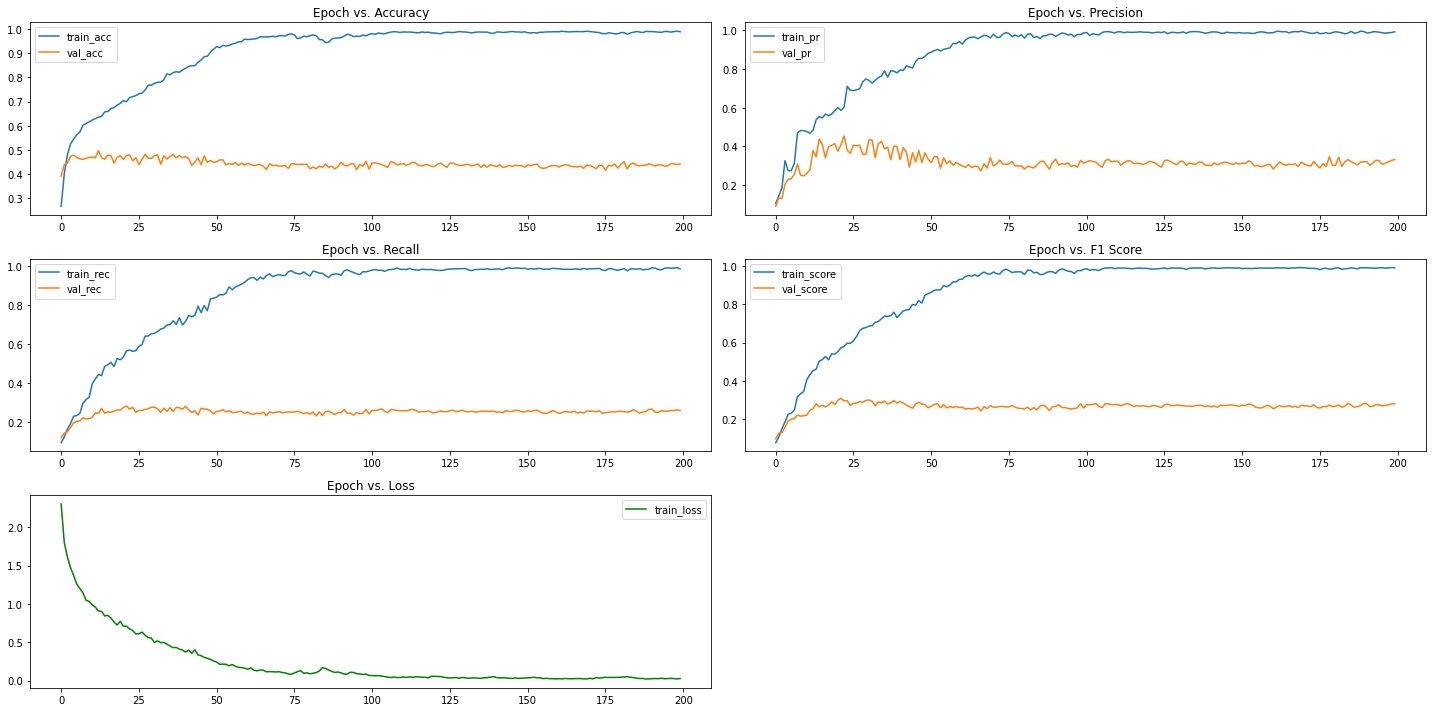

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(20, 10))
df.plot(
    y=["train_acc", "val_acc"],
    title="Epoch vs. Accuracy",
    ax=ax[0, 0],
    legend=True,
)
df.plot(y=["train_pr", "val_pr"], title="Epoch vs. Precision", ax=ax[0, 1])
df.plot(y=["train_rec", "val_rec"], title="Epoch vs. Recall", ax=ax[1, 0])
df.plot(
    y=["train_score", "val_score"],
    title="Epoch vs. F1 Score",
    ax=ax[1, 1],
)
df.plot(y=["train_loss"], title="Epoch vs. Loss", ax=ax[2, 0], color="green")
# Remove the empty subplot
fig.delaxes(ax[2, 1])
plt.tight_layout()
plt.savefig(f"{save_name}.jpg")
plt.show()